In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving train.csv to train.csv


In [ ]:
from zipfile import ZipFile
file_name = "train.zip"

with ZipFile(file_name,"r") as zip:
  zip.extractall()
  print("Done") 

Done


In [ ]:
file_name2 = "test.zip"

with ZipFile(file_name2,"r") as zip:
  zip.extractall()
  print("Done") 

Done


In [ ]:
import os 
os.getcwd()

labels = pd.read_csv(r"/content/train.csv")
submission = pd.read_csv(r"/content/sample_submission.csv")

train_path = r"/content/train"
test_path = r"/content/test"

In [ ]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [ ]:
labels.tail()

,id,has_cactus
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0
17499,fffd9e9b990eba07c836745d8aef1a3a.jpg,1


In [ ]:
labels.has_cactus.unique()

array([1, 0])

In [ ]:
labels.has_cactus.value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

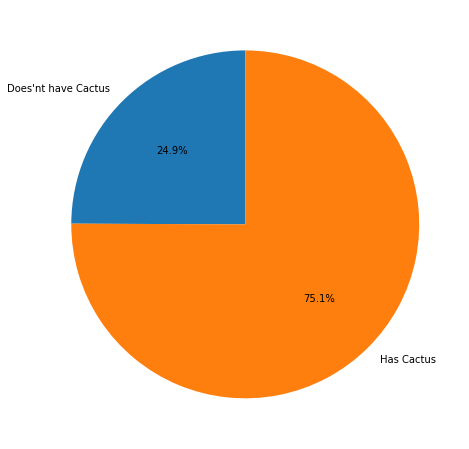

In [ ]:
label = ["Does'nt have Cactus","Has Cactus"]
plt.figure(figsize=(8,8))
plt.pie(labels.groupby("has_cactus").size(),labels = label,autopct="%1.1f%%",startangle=90)
plt.show()

Image Pre-processing

Images in dataset do not usually have the same pixel intensity and dimensions. Now we will pre-process the dataset by standardizing the pixel values.

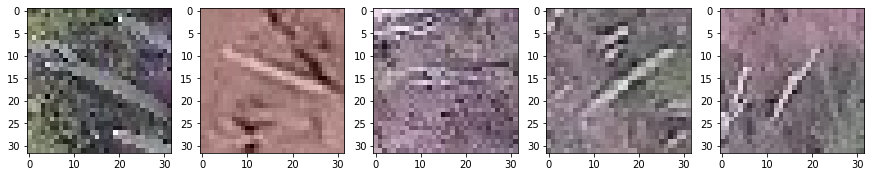

In [ ]:
import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize = (15,5))

for i,idx in enumerate(labels[labels["has_cactus"] == 1]["id"][-5:]):
  path = os.path.join(train_path,idx)
  ax[i].imshow(img.imread(path))
  

Above are the images with cactus

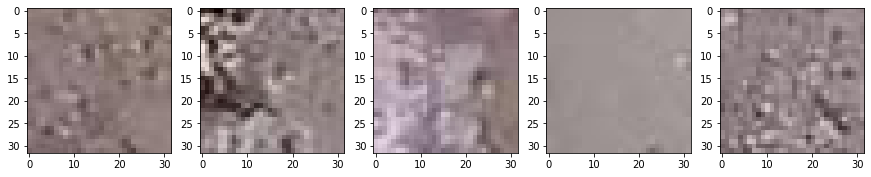

In [ ]:
fig,ax = plt.subplots(1,5,figsize = (15,5))

for i,idx in enumerate(labels[labels["has_cactus"]==0]["id"][-5:]):
  path = os.path.join(train_path,idx)
  ax[i].imshow(img.imread(path))

Above are the images without cactus

In [ ]:

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))])

valid_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))])

Splitting Dataset

In [ ]:
labels.shape

(17500, 2)

In [ ]:
train,valid_data = train_test_split(labels,stratify = labels.has_cactus,test_size = 0.2)

In [ ]:
train.values


array([['62eae7cb92e1b91b0198bda1e4bb8851.jpg', 1],
       ['16f59c3ab4bbd6e7eae4f177a2f4f5e1.jpg', 1],
       ['c86dba5e758a1fdab90849f69076c9a7.jpg', 1],
       ...,
       ['3b5483a2fb6608939c38531785b8b328.jpg', 1],
       ['ad1fa5f6122e9c8533d786352ddb0db4.jpg', 1],
       ['11e44a75e6452cbd4c6c6d475e75506a.jpg', 1]], dtype=object)

In [ ]:
valid_data.values

array([['bdc8ae12d71d1bb096dd27efaf6ef627.jpg', 1],
       ['4f15ad38d82ea4077168e8213d90603e.jpg', 0],
       ['205dd782dc2c91a117a755dba0052970.jpg', 1],
       ...,
       ['40f1009c934c2ea212d420277a871f85.jpg', 1],
       ['82d433e878de47ccd5770f93e516bd21.jpg', 1],
       ['74f1f2f8ea1f732ee57cf3bf13904b9c.jpg', 1]], dtype=object)

In [ ]:
class CactiDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
train_data = CactiDataset(train, train_path, train_transform )
valid_data = CactiDataset(valid_data, train_path, valid_transform )
test_data = CactiDataset(submission, test_path, test_transform )

In [ ]:
train_loader = DataLoader(dataset = train_data, batch_size = 8, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = 8, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = 8, shuffle=False, num_workers=0)

In [ ]:
# Defining Network
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(3,75,5)
    self.pool = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(75,80,5)
    self.conv2_drop = nn.Dropout2d(0.2)
    self.conv3 = nn.Conv2d(80,101,5)
    self.fc1 = nn.Linear(101*1*1,80)
    self.fc2 = nn.Linear(80,40)
    self.fc3 = nn.Linear(40,2)

  def forward(self,x):
    x = F.relu(self.pool(self.conv1(x)))
    x = F.relu(self.pool(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = x.view(-1,101*1*1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x


my_net = Net()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)

cuda:0


In [ ]:
my_net.to(device)

Net(
  (conv1): Conv2d(3, 75, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(75, 80, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(80, 101, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=101, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=2, bias=True)
)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_net.parameters(),lr = 0.001)


%%time
keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, 51):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    my_net.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = my_net(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    my_net.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = my_net(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

In [ ]:
%%time 

#keeping-track-of-losses 
train_losses = [] 
valid_losses = []

for epoch in range(1,16):

# keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
 
    # training-the-model
    my_net.train()
    for data, target in train_loader:
    # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
 
    # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
    # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = my_net(data)
    # calculate-the-batch-loss
        loss = criterion(output, target)
    # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
    # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
    # update-training-loss
        train_loss += loss.item() * data.size(0)
 
# validate-the-model
    my_net.eval()
    for data, target in valid_loader:
 
        data = data.to(device)
        target = target.to(device)
 
        output = my_net(data)
 
        loss = criterion(output, target)
 
    # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
 
# calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
 
# print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.160847 	Validation Loss: 0.056059
Epoch: 2 	Training Loss: 0.095922 	Validation Loss: 0.064922
Epoch: 3 	Training Loss: 0.068195 	Validation Loss: 0.041001
Epoch: 4 	Training Loss: 0.048148 	Validation Loss: 0.030640
Epoch: 5 	Training Loss: 0.040126 	Validation Loss: 0.021800
Epoch: 6 	Training Loss: 0.055329 	Validation Loss: 0.065948
Epoch: 7 	Training Loss: 0.058706 	Validation Loss: 0.022649
Epoch: 8 	Training Loss: 0.048276 	Validation Loss: 0.023537
Epoch: 9 	Training Loss: 0.055289 	Validation Loss: 0.027138
Epoch: 10 	Training Loss: 0.019915 	Validation Loss: 0.047927
Epoch: 11 	Training Loss: 0.018824 	Validation Loss: 0.033400
Epoch: 12 	Training Loss: 0.050411 	Validation Loss: 0.047517
Epoch: 13 	Training Loss: 0.057732 	Validation Loss: 0.045780
Epoch: 14 	Training Loss: 0.038730 	Validation Loss: 0.048891
Epoch: 15 	Training Loss: 0.022838 	Validation Loss: 0.022401
CPU times: user 3min 52s, sys: 7.62 s, total: 3min 59s
Wall time: 4min


In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in valid_loader:
    images, labels = data[0].to(device),data[1].to(device)
    outputs1 = my_net(images)
    _,predicted = torch.max(outputs1.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


print(f"Accuracy of the network on the validation set is: {100*correct/total}%")

Accuracy of the network on the validation set is: 99.34285714285714%


In [ ]:
my_net.eval()
predict = []

for batch_1, (data,target) in enumerate(test_loader):
  data,target = data.to(device),target.to(device)
  output = my_net(data)

  pr = output[:,1].detach().cpu().numpy()
  for i in pr:
    predict.append(i)

In [ ]:
submission["has_cactus"] = predict

In [ ]:
len(predict)

4000

In [ ]:
submission.shape

(4000, 2)

In [ ]:
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,6.554306
1,0017242f54ececa4512b4d7937d1e21e.jpg,17.912106
2,001ee6d8564003107853118ab87df407.jpg,-2.401576
3,002e175c3c1e060769475f52182583d0.jpg,-5.428729
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,3.292339


In [ ]:
submission.to_csv("submit.csv",index = False)